In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
import geoplot
import plotly_express as px
import calendar
import dataframe_image as dfi
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif, RFECV

import xgboost as xgb


import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

SEED = 456
#TEST = 0.2
PATH = ""

In [2]:
X_train = pd.read_csv(PATH + "Data/X_train_restaurants.csv", index_col = [0])
y_train = pd.read_csv(PATH + "Data/y_train_restaurants.csv", index_col = [0])

X_test = pd.read_csv(PATH + "Data/X_test_restaurants.csv", index_col = [0])
y_test = pd.read_csv(PATH + "Data/y_test_restaurants.csv", index_col = [0])

In [3]:
X_train

,BORO,CUISINE DESCRIPTION,INSPECTION DATE,VIOLATION DESCRIPTION,SCORE,INSPECTION TYPE,Latitude,Longitude,INSPECTION PURPOSE,POST COVID,...,DAYS SINCE LAST INSPECTION,YEAR,MONTH,DAY,TOTAL INSPECTIONS,RISKY BUSINESS,MONTHS OPERATING,AVERAGE VIOLATIONS,AVERAGE CRITICAL FLAGS,AVERAGE SCORE
0,Bronx,Pizza,2020-03-05,Evidence of mice or live mice present in facil...,7.0,Cycle,40.845353,-73.865506,Initial,0,...,0,2020,3,5,2,0,28,1,1,4
1,Manhattan,American,2022-10-26,Accurate thermometer not provided or properly ...,10.0,Cycle,40.771553,-73.961387,Initial,1,...,0,2022,10,26,1,0,0,2,1,10
2,Brooklyn,American,2022-06-09,Live roaches present in facility's food and/or...,0.0,Cycle,40.618305,-73.991027,Initial,1,...,0,2022,6,9,3,0,9,4,2,0
3,Bronx,Latin American,2019-06-13,Food Protection Certificate not held by superv...,26.0,Cycle,40.869540,-73.827123,Initial,0,...,0,2019,6,13,3,0,35,3,2,9
4,Bronx,Other,2022-10-27,Non-food contact surface or equipment made of ...,10.0,Pre-permit,40.834032,-73.853141,Initial,1,...,0,2022,10,27,1,0,0,2,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16471,Manhattan,Other,2022-05-03,"Sanitized equipment or utensil, including in-u...",8.0,Cycle,40.706014,-74.011333,Initial,1,...,0,2022,5,3,2,0,12,2,1,4
16472,Brooklyn,Other,2022-12-05,"Food, supplies, and equipment not protected fr...",7.0,Pre-permit,40.716792,-73.962076,Initial,1,...,0,2022,12,5,1,0,0,2,1,7
16473,Queens,Caribbean,2020-02-22,Evidence of mice or live mice present in facil...,11.0,Pre-permit,40.685121,-73.830120,Initial,0,...,0,2020,2,22,2,0,30,2,1,6
16474,Manhattan,American,2020-01-06,Food not protected from potential source of co...,6.0,Cycle,40.754439,-73.987150,Initial,0,...,0,2020,1,6,3,0,31,3,2,2


## Visualizations

/var/folders/3r/2gdxtbds6szcszj9bg_tdb_h0000gn/T/ipykernel_95675/117254287.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


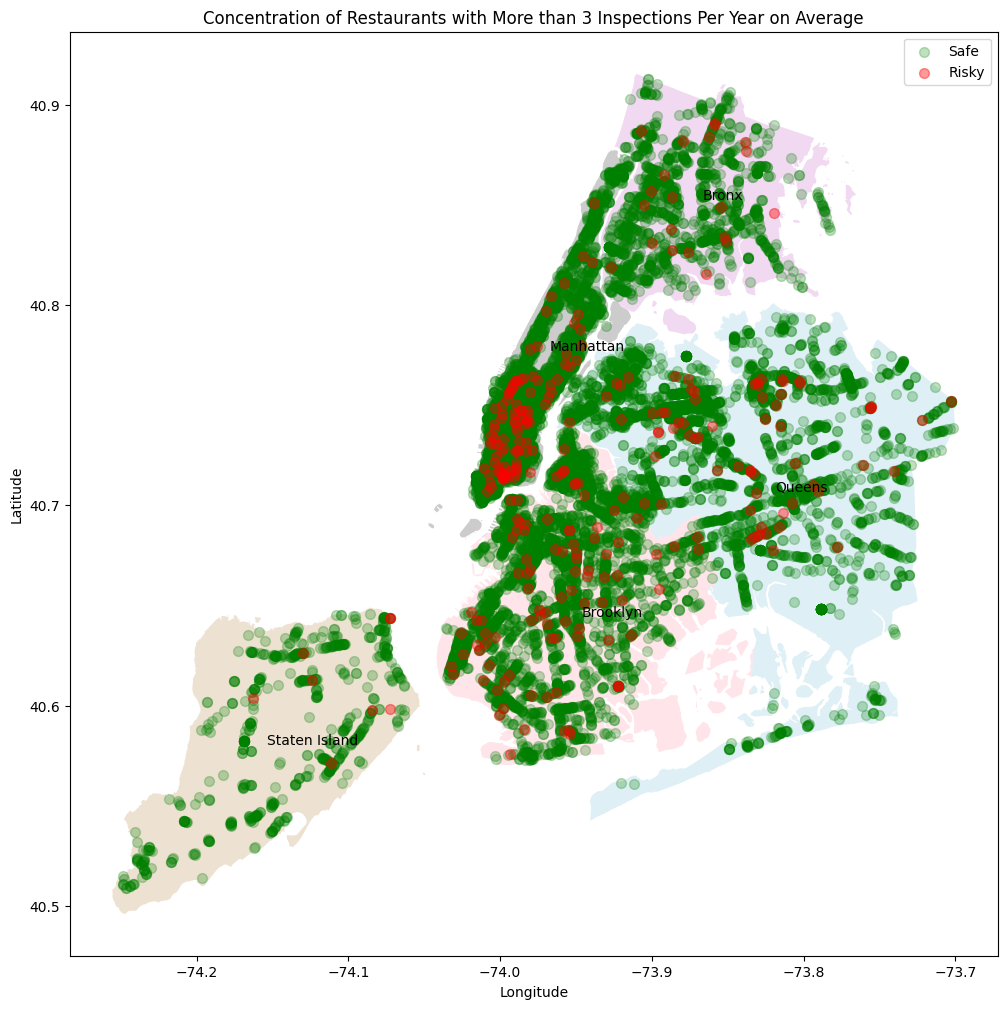

In [4]:
# map of risk by borough

crs = {'init':'epsg:4326'}

boroughs = geopandas.read_file(geoplot.datasets.get_path("nyc_boroughs"))

geo_df = geopandas.GeoDataFrame(X_train, crs = crs, geometry = geopandas.points_from_xy(X_train["Longitude"], 
                                                                                        X_train["Latitude"]))

fig, ax = plt.subplots(figsize = (12, 12))
boroughs.plot(ax = ax, alpha = 0.4, color = ["tan", "lightblue", "pink", "grey", "plum"], label = boroughs.BoroName)
boroughs.apply(lambda x: ax.annotate(text = x["BoroName"], xy = x.geometry.centroid.coords[0]), axis = 1)
geo_df[geo_df["RISKY BUSINESS"] == 0].plot(ax = ax, markersize = 50, alpha = 0.25, color = "green", label = "Safe")
geo_df[geo_df["RISKY BUSINESS"] != 0].plot(ax = ax, markersize = 50, alpha = 0.4, color = "red", label = "Risky")
plt.title("Concentration of Restaurants with More than 3 Inspections Per Year on Average")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.legend()
#plt.savefig(PATH + "Results/risk map.png")
plt.show()

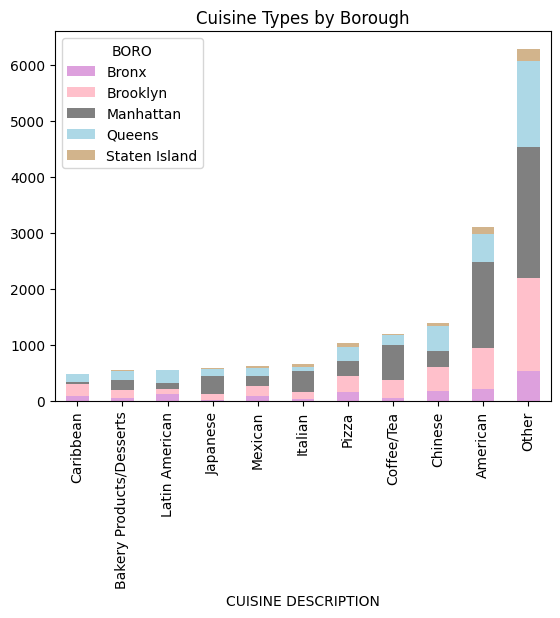

In [5]:
sorted_cuisines = pd.crosstab(X_train["CUISINE DESCRIPTION"], X_train["BORO"])
sorted_cuisines["Sum"] = sorted_cuisines.sum(axis = 1)
sorted_cuisines = sorted_cuisines.sort_values(by = "Sum")
sorted_cuisines = sorted_cuisines.drop("Sum", axis = 1)
sorted_cuisines.plot(kind = "bar", stacked = True, color = ["plum", "pink", "grey", "lightblue", "tan"])
plt.title("Cuisine Types by Borough")
#plt.savefig(PATH + "Results/borough cuisines.png")
plt.show()

In [6]:
inspections_overtime = pd.crosstab(X_train["MONTHS OPERATING"], X_train["TOTAL INSPECTIONS"])

def highlight(val, df = X_train):
    lim = np.ceil(df.shape[0] * 0.05)
    sig = lim / 5
    if val >= lim:
        return "background-color: blue"
    elif val >= sig:
        return "color: blue"
    
inspections_overtime = inspections_overtime.style.applymap(highlight)
inspections_overtime

dfi.export(inspections_overtime, PATH + "Results/inspection table.png")

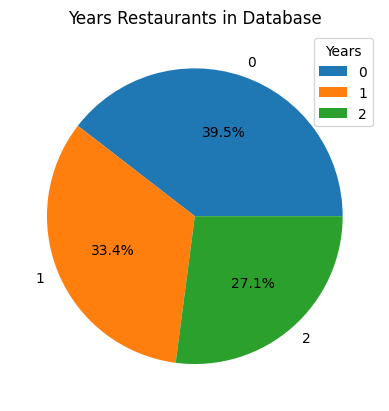

In [7]:
X_train["YEARS"] = X_train["MONTHS OPERATING"]//12

plt.pie(X_train["YEARS"].value_counts().values, labels = X_train["YEARS"].value_counts().index, autopct= '%.1f%%')
plt.legend(title = "Years")
plt.title("Years Restaurants in Database")
#plt.savefig(PATH + "Results/years in data.png")
plt.show()

In [8]:
X_train = X_train.drop(["YEARS"], axis = 1)
X_train["MONTHS OPERATING"].max()

35

## Risk Assessment

In [9]:
X_train

,BORO,CUISINE DESCRIPTION,INSPECTION DATE,VIOLATION DESCRIPTION,SCORE,INSPECTION TYPE,Latitude,Longitude,INSPECTION PURPOSE,POST COVID,...,DAYS SINCE LAST INSPECTION,YEAR,MONTH,DAY,TOTAL INSPECTIONS,RISKY BUSINESS,MONTHS OPERATING,AVERAGE VIOLATIONS,AVERAGE CRITICAL FLAGS,AVERAGE SCORE
0,Bronx,Pizza,2020-03-05,Evidence of mice or live mice present in facil...,7.0,Cycle,40.845353,-73.865506,Initial,0,...,0,2020,3,5,2,0,28,1,1,4
1,Manhattan,American,2022-10-26,Accurate thermometer not provided or properly ...,10.0,Cycle,40.771553,-73.961387,Initial,1,...,0,2022,10,26,1,0,0,2,1,10
2,Brooklyn,American,2022-06-09,Live roaches present in facility's food and/or...,0.0,Cycle,40.618305,-73.991027,Initial,1,...,0,2022,6,9,3,0,9,4,2,0
3,Bronx,Latin American,2019-06-13,Food Protection Certificate not held by superv...,26.0,Cycle,40.869540,-73.827123,Initial,0,...,0,2019,6,13,3,0,35,3,2,9
4,Bronx,Other,2022-10-27,Non-food contact surface or equipment made of ...,10.0,Pre-permit,40.834032,-73.853141,Initial,1,...,0,2022,10,27,1,0,0,2,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16471,Manhattan,Other,2022-05-03,"Sanitized equipment or utensil, including in-u...",8.0,Cycle,40.706014,-74.011333,Initial,1,...,0,2022,5,3,2,0,12,2,1,4
16472,Brooklyn,Other,2022-12-05,"Food, supplies, and equipment not protected fr...",7.0,Pre-permit,40.716792,-73.962076,Initial,1,...,0,2022,12,5,1,0,0,2,1,7
16473,Queens,Caribbean,2020-02-22,Evidence of mice or live mice present in facil...,11.0,Pre-permit,40.685121,-73.830120,Initial,0,...,0,2020,2,22,2,0,30,2,1,6
16474,Manhattan,American,2020-01-06,Food not protected from potential source of co...,6.0,Cycle,40.754439,-73.987150,Initial,0,...,0,2020,1,6,3,0,31,3,2,2


In [10]:
X_train["RISKY BUSINESS"].value_counts()

RISKY BUSINESS
0    16187
1      289
Name: count, dtype: int64

In [11]:
X_train["RISKY BUSINESS"] = X_train["RISKY BUSINESS"].astype("str")
fig = px.scatter_3d(X_train, x = 'AVERAGE VIOLATIONS', y = 'AVERAGE CRITICAL FLAGS', z = 'AVERAGE SCORE', color = 'RISKY BUSINESS')
fig.show()

In [12]:
X_train["INSPECTION TYPE"].value_counts()

INSPECTION TYPE
Cycle           11458
Pre-permit       4998
Inter-Agency       20
Name: count, dtype: int64

In [13]:
X_train["INSPECTION PURPOSE"].value_counts()

INSPECTION PURPOSE
Initial          15641
Re-inspection      730
Compliance          69
Reopening           36
Name: count, dtype: int64

In [14]:
y_train = y_train["GRADED"].astype("str")
y_train.value_counts()


# Ungraded when initial inspection results in score > 13 (non A)
# also: reopening, monitoring (after failing reinspection (score > 28)), 
# new restaurants not open to public, and inspections from complaints

GRADED
1    8467
0    8009
Name: count, dtype: int64

In [15]:
z_train = X_train["RISKY BUSINESS"].astype('int')
z_test = X_test["RISKY BUSINESS"].astype('int')

X_train = X_train.drop(["VIOLATION DESCRIPTION", "Latitude", "Longitude", "YEAR", "MONTH", "DAY", "INSPECTION DATE", 
                        "SCORE", "CRITICAL FLAGS PER INSPECTION", "VIOLATIONS PER INSPECTION", "RISKY BUSINESS"], axis = 1)

X_test = X_test.drop(["VIOLATION DESCRIPTION", "Latitude", "Longitude", "YEAR", "MONTH", "DAY", "INSPECTION DATE", 
                      "SCORE", "CRITICAL FLAGS PER INSPECTION", "VIOLATIONS PER INSPECTION", "RISKY BUSINESS"], axis = 1)

In [16]:
X_train["INSPECTION PURPOSE"].value_counts()

INSPECTION PURPOSE
Initial          15641
Re-inspection      730
Compliance          69
Reopening           36
Name: count, dtype: int64

In [17]:
initial_inspection = X_train.loc[X_train["INSPECTION PURPOSE"] == "Initial"]
initial_inspection = initial_inspection.drop(["INSPECTION PURPOSE"], axis = 1)

initial_graded = y_train.iloc[initial_inspection.index]

initial_test_index = X_test.loc[X_test["INSPECTION PURPOSE"] == "Initial"]
initial_test = X_test.loc[X_test["INSPECTION PURPOSE"] == "Initial"]
initial_test = initial_test.drop(["INSPECTION PURPOSE"], axis = 1)
initial_testgrade = y_test.iloc[initial_test_index.index]["GRADED"].astype('str')

initial_inspection["INSPECTION TYPE"].value_counts()

INSPECTION TYPE
Cycle           10794
Pre-permit       4827
Inter-Agency       20
Name: count, dtype: int64

In [18]:
X_train = X_train.drop(["INSPECTION TYPE", "INSPECTION PURPOSE", "DAYS SINCE LAST INSPECTION"], axis = 1)
X_test = X_test.drop(["INSPECTION TYPE", "INSPECTION PURPOSE", "POST COVID"], axis = 1)
# risk == restaurant level (doesn't need inspection level variables)

cols = ['BORO', 'CUISINE DESCRIPTION']
X_train = pd.get_dummies(X_train, columns = cols, dtype = int)
X_test = pd.get_dummies(X_test, columns = cols, dtype = int)

In [19]:
#initial_inspection["GRADED"] = initial_graded
#fig = px.scatter_3d(initial_inspection, x = 'AVERAGE VIOLATIONS', y = 'AVERAGE CRITICAL FLAGS', z = 'AVERAGE SCORE', color = 'GRADED')
#fig.show()

In [20]:
#initial_inspection = initial_inspection.drop(["GRADED"], axis = 1)
initial_inspection = pd.get_dummies(initial_inspection, columns = cols, dtype = int)
#initial_graded = pd.get_dummies(initial_graded, columns = cols)

initial_test = pd.get_dummies(initial_test, columns = cols, dtype = int)
#initial_testgrade = pd.get_dummies(initial_testgrade, columns = cols)

### Anomaly Detection - Risky Business

(Many Inspections Relative to Time in Dataset)

In [21]:
X_train.columns

Index(['POST COVID', 'TOTAL INSPECTIONS', 'MONTHS OPERATING',
       'AVERAGE VIOLATIONS', 'AVERAGE CRITICAL FLAGS', 'AVERAGE SCORE',
       'BORO_Bronx', 'BORO_Brooklyn', 'BORO_Manhattan', 'BORO_Queens',
       'BORO_Staten Island', 'CUISINE DESCRIPTION_American',
       'CUISINE DESCRIPTION_Bakery Products/Desserts',
       'CUISINE DESCRIPTION_Caribbean', 'CUISINE DESCRIPTION_Chinese',
       'CUISINE DESCRIPTION_Coffee/Tea', 'CUISINE DESCRIPTION_Italian',
       'CUISINE DESCRIPTION_Japanese', 'CUISINE DESCRIPTION_Latin American',
       'CUISINE DESCRIPTION_Mexican', 'CUISINE DESCRIPTION_Other',
       'CUISINE DESCRIPTION_Pizza'],
      dtype='object')

In [22]:
#plt.figure(figsize=(12, 12))
#sns.heatmap(X_train.corr())

In [23]:
z_train.value_counts()

RISKY BUSINESS
0    16187
1      289
Name: count, dtype: int64

In [24]:
#from pyod.models.knn import KNN


#risky = (z_train.values == 1).sum()
#flag_pct = risky/len(z_train)

#parameters = {"contamination" : [flag_pct, 0.03, 0.05], "n_neighbors" : [5, 9, 15], "method" : ['mean', 'median', 'largest']}
#knn_anom = KNN() 
#clf = GridSearchCV(knn_anom, param_grid = parameters, scoring = 'f1_weighted')
#clf.fit(X_train, z_train) 

#c = clf.best_params_["contamination"]
#m = clf.best_params_["method"]
#n = clf.best_params_["n_neighbors"]

In [25]:
#best_knn = KNN(contamination = c, method = m, n_neighbors = n)
#best_knn.fit(X_train, z_train)

In [26]:
# You can print this to see all the prediction scores 
#scores_pred = clf.decision_function(X_train)*-1
  
#z_pred = best_knn.predict(X_train) 
#n_errors = (z_pred != z_train).sum()
#n_errors

In [27]:
#clf = KNN(contamination = flag_pct, method = "mean") 
#clf.fit(X_train) 
  
# You can print this to see all the prediction scores 
#scores_pred = clf.decision_function(X_train)*-1
  
#z_pred = clf.predict(X_train) 
#n_errors = (z_pred != z_train).sum()
#n_errors

In [28]:
#print(scores_pred)

In [29]:
#ConfusionMatrixDisplay.from_predictions(z_train, z_pred, display_labels={"Normal":0, "Risky":1}, normalize = 'true')
#plt.show()

In [30]:
# on test data

#z_pred_test = best_knn.predict(X_test) 
#n_errors_test = (z_pred_test != z_test).sum()
#n_errors_test

In [31]:
#ConfusionMatrixDisplay.from_predictions(z_test, z_pred_test, display_labels={"Normal":0, "Risky":1}, normalize = "true")
#plt.show()

### Classification - Graded

(Restaurants that Pass or Fail Initial Inspection)

In [32]:
initial_inspection = pd.get_dummies(initial_inspection, columns = ["INSPECTION TYPE"], dtype = int)
initial_test = pd.get_dummies(initial_test, columns = ["INSPECTION TYPE"], dtype = int)

initial_inspection

,POST COVID,DAYS SINCE LAST INSPECTION,TOTAL INSPECTIONS,MONTHS OPERATING,AVERAGE VIOLATIONS,AVERAGE CRITICAL FLAGS,AVERAGE SCORE,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,...,CUISINE DESCRIPTION_Coffee/Tea,CUISINE DESCRIPTION_Italian,CUISINE DESCRIPTION_Japanese,CUISINE DESCRIPTION_Latin American,CUISINE DESCRIPTION_Mexican,CUISINE DESCRIPTION_Other,CUISINE DESCRIPTION_Pizza,INSPECTION TYPE_Cycle,INSPECTION TYPE_Inter-Agency,INSPECTION TYPE_Pre-permit
0,0,0,2,28,1,1,4,1,0,0,...,0,0,0,0,0,0,1,1,0,0
1,1,0,1,0,2,1,10,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1,0,3,9,4,2,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,3,35,3,2,9,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,1,0,1,0,2,1,10,1,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16471,1,0,2,12,2,1,4,0,0,1,...,0,0,0,0,0,1,0,1,0,0
16472,1,0,1,0,2,1,7,0,1,0,...,0,0,0,0,0,1,0,0,0,1
16473,0,0,2,30,2,1,6,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16474,0,0,3,31,3,2,2,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [33]:
initial_graded.value_counts()

GRADED
0    7926
1    7715
Name: count, dtype: int64

In [34]:
#sns.heatmap(initial_inspection.iloc[:, 0:7].corr())

### Feature Importance

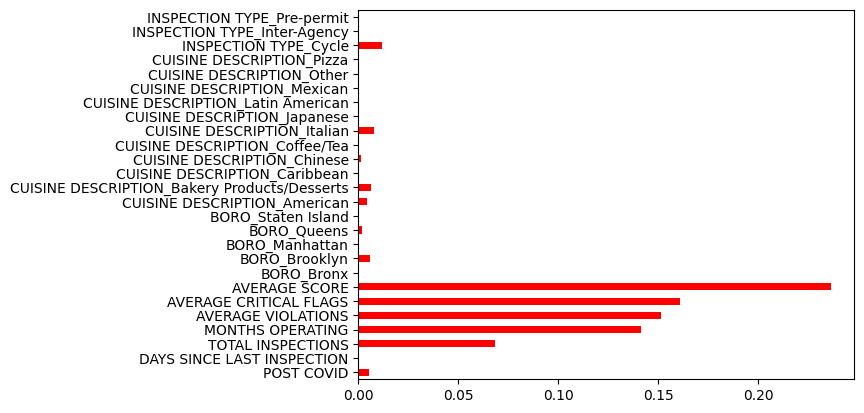

In [35]:
importances = mutual_info_classif(initial_inspection, initial_graded)
f_imp = pd.Series(importances, initial_inspection.columns[0:len(initial_inspection.columns)])
f_imp.plot(kind = 'barh', color = 'red')
plt.show()

# mutual information - measure of dependency (5 variables have notable levels of dependency with risk)

In [36]:
rfe = RFECV(RandomForestClassifier(min_samples_leaf = 250, class_weight = 'balanced', max_depth = 5, 
                                   random_state = SEED))
rfe.fit(initial_inspection, initial_graded)

rfe.ranking_

# feature importance by recursively evaluating smaller sets of features on (here) a random forest classifier 
# (feature pruning with cross validation)

array([ 2, 21,  1,  1,  1,  1,  1, 12,  9, 10, 11, 16,  5, 17, 13,  8,  6,
       22, 20, 19, 15,  7, 14,  3, 18,  4])

In [37]:
initial_inspection.columns[2:7]

# same 5 variables as mutual info
# directly related to TOTAL INSPECTIONS and MONTHS OPERATING (variable creation)

Index(['TOTAL INSPECTIONS', 'MONTHS OPERATING', 'AVERAGE VIOLATIONS',
       'AVERAGE CRITICAL FLAGS', 'AVERAGE SCORE'],
      dtype='object')

In [38]:
initial_inspection = initial_inspection.iloc[:, 2:7]
initial_test = initial_test.iloc[:, 2:7]

### Logistic Regression

In [39]:
log_reg = LogisticRegression(random_state = SEED)
log_reg.fit(initial_inspection, initial_graded)

log_pred = log_reg.predict(initial_test)
log_f1 = round(f1_score(initial_testgrade, log_pred, average = 'weighted'), 3)
log_f1

0.859

In [40]:
log_pred_prob = log_reg.predict_proba(initial_test)
log_auc = round(roc_auc_score(initial_testgrade, log_pred, average = "weighted"), 3)
log_auc

0.86

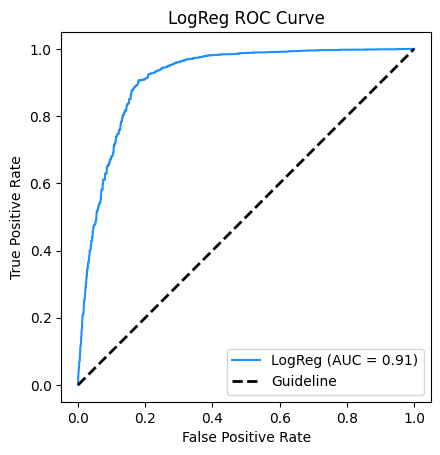

In [41]:
# ROC curve attempt 1

def plot_roc_curve(model, actual, pred):
    RocCurveDisplay.from_predictions(actual.astype('int'), pred[:, 1], pos_label = 1, name = f"{model}",
        color = "dodgerblue")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("{} ROC Curve".format(model))
    plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Guideline')
    plt.legend()
    #plt.savefig(PATH + "Results/{}.png".format(model + "_ROC"))
    plt.show()

plot_roc_curve("LogReg", initial_testgrade, log_pred_prob)

In [42]:
# roc curve attempt 2

#label_binarizer = LabelBinarizer().fit(initial_graded)
#y_onehot_test = label_binarizer.transform(initial_testgrade)

#def plot_roc_curve(model, pred, class_of_interest):
    #class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    #RocCurveDisplay.from_predictions(y_onehot_test[:, 0], pred[:, class_id], name = f"{model}",
        #color = "dodgerblue")
    #plt.axis("square")
    #plt.xlabel("False Positive Rate")
    #plt.ylabel("True Positive Rate")
    #lt.title("{} ROC Curve".format(model))
    #plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Guideline')
    #plt.legend()
    #plt.savefig(PATH + "Results/{}.png".format(model + "_ROC"))
    #plt.show()

#plot_roc_curve("RF", rf_pred_prob, "1")
#plot_roc_curve("RF", rf_pred_prob, "0")

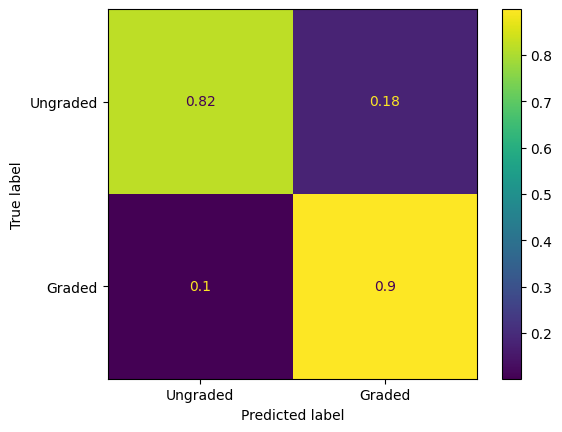

In [43]:
ConfusionMatrixDisplay.from_predictions(initial_testgrade, log_pred, display_labels={"Ungraded":0, "Graded":1}, normalize = 'true')
plt.show()

### Random Forest

In [44]:
kfold = KFold(n_splits = 5)
parameters = {'class_weight':[None, 'balanced'], 'min_samples_leaf':[250, 500, 750, 1000]}
rf = RandomForestClassifier(max_depth = 5, random_state = SEED)
best_rf = GridSearchCV(rf, parameters, cv = kfold)

best_rf.fit(initial_inspection, initial_graded)
best_rf.best_params_

{'class_weight': None, 'min_samples_leaf': 250}

In [45]:
rf_pred = best_rf.predict(initial_test)
rf_f1 = round(f1_score(initial_testgrade, rf_pred, average = 'weighted'), 3)
rf_f1

0.919

In [46]:
rf_pred_prob = best_rf.predict_proba(initial_test)
rf_auc = round(roc_auc_score(initial_testgrade, rf_pred, average = "weighted"), 3)
rf_auc

0.92

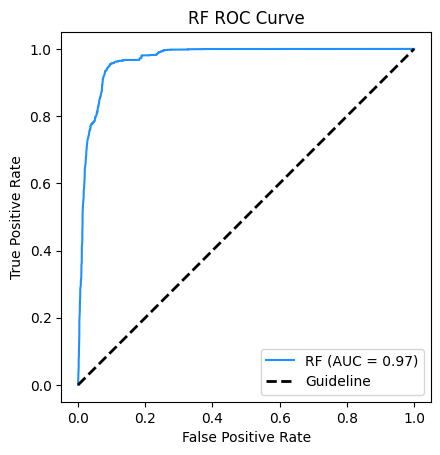

In [47]:
plot_roc_curve("RF", initial_testgrade, rf_pred_prob)

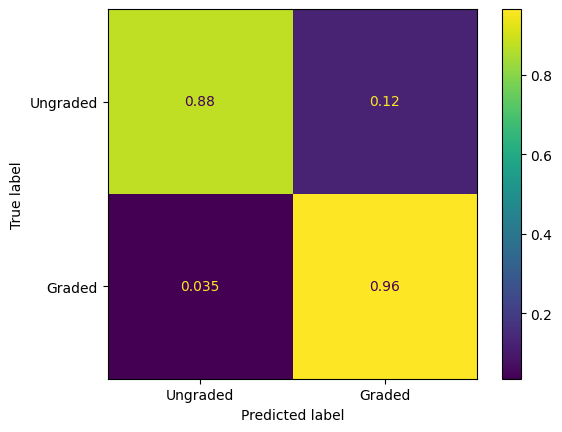

In [48]:
ConfusionMatrixDisplay.from_predictions(initial_testgrade, rf_pred, display_labels={"Ungraded":0, "Graded":1}, normalize = 'true')
plt.show()

### XGB

In [49]:
le = LabelEncoder()
graded_encode = le.fit_transform(initial_graded)


parameters = {'learning_rate':[0.1, 0.01, 0.001], 'gamma':[0, 1, 2, 5]}
xgb_model = xgb.XGBClassifier(max_depth = 5, subsample = 0.5, random_state = SEED)
best_xgb = GridSearchCV(xgb_model, parameters, cv = kfold)
best_xgb.fit(initial_inspection, initial_graded.astype("int"))
best_xgb.best_params_

{'gamma': 0, 'learning_rate': 0.1}

In [50]:
xgb_pred = best_xgb.predict(initial_test)
xgb_pred = le.inverse_transform(xgb_pred)

xgb_f1 = round(f1_score(initial_testgrade, xgb_pred, average = 'weighted'), 3)
xgb_f1

0.947

In [51]:
xgb_pred_prob = best_xgb.predict_proba(initial_test)
xgb_auc = round(roc_auc_score(initial_testgrade, xgb_pred, multi_class = "ovr", average = "weighted"), 3)
xgb_auc

0.948

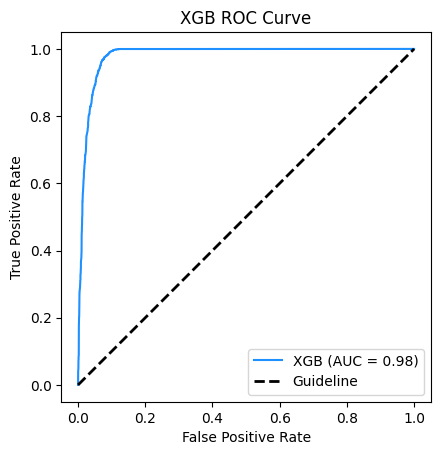

In [52]:
plot_roc_curve("XGB", initial_testgrade, xgb_pred_prob)

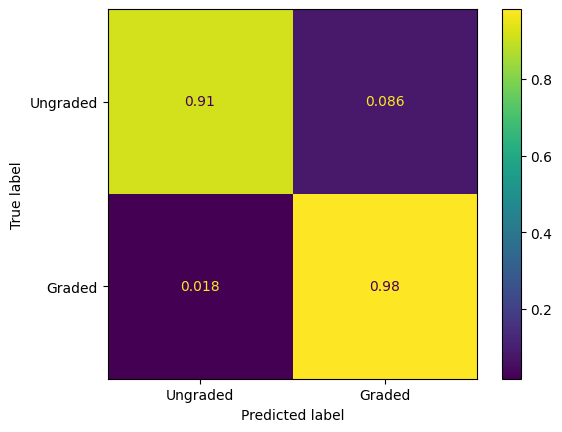

In [53]:
ConfusionMatrixDisplay.from_predictions(initial_testgrade, xgb_pred, display_labels={"Ungraded":0, "Graded":1}, normalize = 'true')
plt.show()